# GLENS land variable analysis - Tye et al. (2022)
Katie Dagon, kdagon@ucar.edu\
Updated Jan 25, 2023

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import nc_time_axis
import cf_xarray 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy
import regionmask

## Bring in dask resources for plotting

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem='5GB'
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem, # Specify resources
    project='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10-20 nodes (10-20 dask workers)
cluster.scale(20)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41333 instead
  f"Port {expected} is already in use.\n"


In [3]:
client

<Client: 'tcp://10.12.206.47:36077' processes=20 threads=20, memory=93.20 GiB>

## Define file paths

In [5]:
ctrl_lnd_path = '/glade/campaign/cesm/collections/GLENS/Control/lnd/proc/tseries/monthly/'
fdbk_lnd_path = '/glade/campaign/cesm/collections/GLENS/Feedback/lnd/proc/tseries/monthly/'

## Define function to read in given variable for three simulations-time periods

In [42]:
def read_var_sims(var):
    
    # variable file paths
    ctrl_lnd_path_var = ctrl_lnd_path+var+'/'
    fdbk_land_path_var = fdbk_lnd_path+var+'/'
    
    # number of ensemble members
    nens = 20
    
    # define ensemble member dim
    ensdim = xr.DataArray(np.array(range(nens)), dims='ens', name='ens')
    dims = [ensdim,'time']
    
    # create file lists
    ctrl_lnd_files = [ctrl_lnd_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
    #print(ctrl_lnd_files)
    fdbk_lnd_files = [fdbk_land_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
    #print(fdbk_lnd_files)
    
    # set ctrl years
    # these variables are needed for preprocess function
    firstyear=2010
    lastyear=2030
    
    # need to define preprocess inside this function to update variable name
    def preprocess(ds):
        import cf_xarray # need to import within preprocessing function to access .cf attribute
        # fix CESM time bounds for monthly output
        attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
        time_bounds = ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
        time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
        ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
        ds.time.attrs, ds.time.encoding = attrs, encoding
        return ds[var].sel(time=slice(str(firstyear), str(lastyear)))
    
    # read one file string at a time, then concat over ensemble members
    dsets=[]
    for ffs in ctrl_lnd_files:
        df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
        dsets.append(df)
    ctrl_lnd_var = xr.concat(dsets,dim=ensdim)
    
    # reset years for feedback
    firstyear=2075
    lastyear=2095
    
    # need to re-define preprocess to update years
    def preprocess(ds):
        import cf_xarray
        attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
        time_bounds = ds.cf.get_bounds('time').load()
        time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
        ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
        ds.time.attrs, ds.time.encoding = attrs, encoding
        return ds[var].sel(time=slice(str(firstyear), str(lastyear)))
    
    # feedback files
    dsets=[]
    for ffs in fdbk_lnd_files:
        df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
        dsets.append(df)
    fdbk_lnd_var = xr.concat(dsets,dim=ensdim)
    
    # RCP8.5 files
    dsets=[]
    for ffs in ctrl_lnd_files:
        df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
        dsets.append(df)
        
    # manually subset because only first 3 RCP8.5 ensemble members cover this time period
    nens_red = 3
    dsets = dsets[:nens_red]
    # new ensemble dim (reduced)
    ensdim_red = xr.DataArray(np.array(range(nens_red)), dims='ens', name='ens')
    rcp_lnd_var = xr.concat(dsets,dim=ensdim_red)

    return(ctrl_lnd_var, fdbk_lnd_var, rcp_lnd_var)

## Define function to calculate three ensemble mean, annual mean differences

In [40]:
diffnames = ['Feedback, 2075-2095 - Control, 2010-2030', 'Feedback, 2075-2095 - RCP8.5, 2075-2095', 'RCP8.5, 2075-2095 - Control, 2010-2030']
nsim = len(diffnames)

In [41]:
def calc_sim_diffs(var):
    var_das = read_var_sims(var)
    var_diffs = [(var_das[1].mean(('time','ens')) - var_das[0].mean(('time','ens'))), # feedback - control
         (var_das[1].mean(('time','ens')) - var_das[2].mean(('time','ens'))), # feedback - rcp
         (var_das[2].mean(('time','ens')) - var_das[0].mean(('time','ens')))] # rcp - control

    return(var_das, var_diffs)

## Calculate differences for relevant land variables

In [43]:
LH, LH_diffs = calc_sim_diffs('EFLX_LH_TOT')

In [47]:
SM10, SM10_diffs = calc_sim_diffs('SOILWATER_10CM')

In [51]:
TLAI, TLAI_diffs = calc_sim_diffs('TLAI')

In [54]:
GPP, GPP_diffs = calc_sim_diffs('GPP')

In [59]:
QSOIL, QSOIL_diffs = calc_sim_diffs('QSOIL')

In [60]:
QVEGE, QVEGE_diffs = calc_sim_diffs('QVEGE')

In [61]:
QVEGT, QVEGT_diffs = calc_sim_diffs('QVEGT')

## Define regions

In [65]:
# suppress shapely warnings (or update cartopy)
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [68]:
regions = ["NSA", "NES", "WAF", "CAF", "SAS"]
ar6 = regionmask.defined_regions.ar6.land
ar6[regions]

<regionmask.Regions>
Name:     AR6 reference regions (land only)
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
10 NSA   N.South-America
11 NES N.E.South-America
21 WAF    Western-Africa
22 CAF    Central-Africa
37 SAS            S.Asia

[5 regions]

## 3-column figures with all three comparisons

### Latent heat flux, 10cm soil moisture, LAI, and GPP

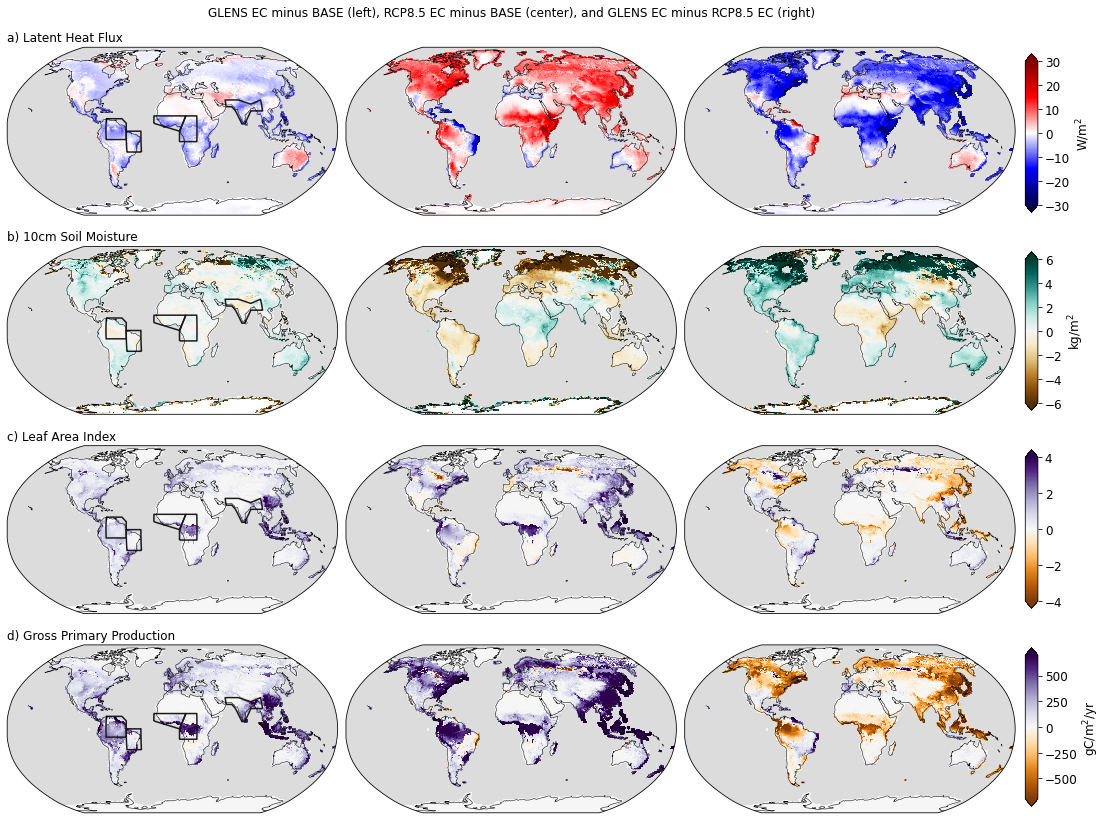

In [69]:
# LHF range
min_a=-30; max_a=30
# SM10 range
min_b=-6; max_b=6
# TLAI range
min_c=-4; max_c=4
# GPP range (gC/m2/yr)
min_d=-700; max_d=700

# LHF colormap
cmap_a = plt.cm.seismic
# SM10 colormap
cmap_b = plt.cm.BrBG
# TLAI colormap
cmap_c = plt.cm.PuOr
# GPP colormap
cmap_d = plt.cm.PuOr

# define ar6 regions
regions = ["NSA", "NES", "WAF", "CAF", "SAS"]
ar6 = regionmask.defined_regions.ar6.land

fig = plt.figure(figsize=(14, 11))

grid = gridspec.GridSpec(nrows=4, ncols=3, figure=fig, left=0., right=1., top=1., bottom=0.,
                         wspace=0.025, hspace=0.025,)

proj = ccrs.PlateCarree()

ax1 = fig.add_subplot(grid[0], projection=ccrs.Robinson())
ax2 = fig.add_subplot(grid[1], projection=ccrs.Robinson())
ax3 = fig.add_subplot(grid[2], projection=ccrs.Robinson())
ax4 = fig.add_subplot(grid[3], projection=ccrs.Robinson())
ax5 = fig.add_subplot(grid[4], projection=ccrs.Robinson()) 
ax6 = fig.add_subplot(grid[5], projection=ccrs.Robinson()) 
ax7 = fig.add_subplot(grid[6], projection=ccrs.Robinson()) 
ax8 = fig.add_subplot(grid[7], projection=ccrs.Robinson())
ax9 = fig.add_subplot(grid[8], projection=ccrs.Robinson())
ax10 = fig.add_subplot(grid[9], projection=ccrs.Robinson())
ax11 = fig.add_subplot(grid[10], projection=ccrs.Robinson())
ax12 = fig.add_subplot(grid[11], projection=ccrs.Robinson())

# add greyed out ocean
ax1.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax3.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax4.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax5.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax6.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax7.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax8.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax9.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax10.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax11.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax12.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# add coastlines
ax1.coastlines(linewidth=0.5, zorder=10)
ax2.coastlines(linewidth=0.5, zorder=10)
ax3.coastlines(linewidth=0.5, zorder=10)
ax4.coastlines(linewidth=0.5, zorder=10)
ax5.coastlines(linewidth=0.5, zorder=10)
ax6.coastlines(linewidth=0.5, zorder=10)
ax7.coastlines(linewidth=0.5, zorder=10)
ax8.coastlines(linewidth=0.5, zorder=10)
ax9.coastlines(linewidth=0.5, zorder=10)
ax10.coastlines(linewidth=0.5, zorder=10)
ax11.coastlines(linewidth=0.5, zorder=10)
ax12.coastlines(linewidth=0.5, zorder=10)

# add regional boxes (to left column only)
ar6[regions].plot(ax=ax1, projection=proj, add_label=False)
ar6[regions].plot(ax=ax4, projection=proj, add_label=False)
ar6[regions].plot(ax=ax7, projection=proj, add_label=False)
ar6[regions].plot(ax=ax10, projection=proj, add_label=False)

# -------- plots

# LHF
# GLENS minus BASE
field, lon = add_cyclic_point(LH_diffs[0], coord=LH_diffs[0].lon)
lat = LH_diffs[0].lat
pl_a = ax1.pcolormesh(lon, lat, field, cmap=cmap_a, vmin=min_a, vmax=max_a, transform=proj)
ax1.set_title('a) Latent Heat Flux', fontsize=12, loc='left')
# RCP minus BASE
field, lon = add_cyclic_point(LH_diffs[2], coord=LH_diffs[2].lon)
lat = LH_diffs[2].lat
pl_a = ax2.pcolormesh(lon, lat, field, cmap=cmap_a, vmin=min_a, vmax=max_a, transform=proj)
# GLENS minus RCP
field, lon = add_cyclic_point(LH_diffs[1], coord=LH_diffs[1].lon)
lat = LH_diffs[1].lat
pl_a = ax3.pcolormesh(lon, lat, field, cmap=cmap_a, vmin=min_a, vmax=max_a, transform=proj)

# SM10
# GLENS minus BASE
field, lon = add_cyclic_point(SM10_diffs[0], coord=SM10_diffs[0].lon)
lat = SM10_diffs[0].lat 
pl_b = ax4.pcolormesh(lon, lat, field, cmap=cmap_b, vmin=min_b, vmax=max_b, transform=proj)
ax4.set_title('b) 10cm Soil Moisture', fontsize=12, loc='left')
# RCP minus BASE
field, lon = add_cyclic_point(SM10_diffs[2], coord=SM10_diffs[2].lon)
lat = SM10_diffs[2].lat 
pl_b = ax5.pcolormesh(lon, lat, field, cmap=cmap_b, vmin=min_b, vmax=max_b, transform=proj)
# GLENS minus RCP
field, lon = add_cyclic_point(SM10_diffs[1], coord=SM10_diffs[1].lon)
lat = SM10_diffs[1].lat 
pl_b = ax6.pcolormesh(lon, lat, field, cmap=cmap_b, vmin=min_b, vmax=max_b, transform=proj)

# TLAI
# GLENS minus BASE
field, lon = add_cyclic_point(TLAI_diffs[0], coord=TLAI_diffs[0].lon)
lat = TLAI_diffs[0].lat 
pl_c = ax7.pcolormesh(lon, lat, field, cmap=cmap_c, vmin=min_c, vmax=max_c, transform=proj)
ax7.set_title('c) Leaf Area Index', fontsize=12, loc='left')
# RCP minus BASE
field, lon = add_cyclic_point(TLAI_diffs[2], coord=TLAI_diffs[2].lon)
lat = TLAI_diffs[2].lat 
pl_c = ax8.pcolormesh(lon, lat, field, cmap=cmap_c, vmin=min_c, vmax=max_c, transform=proj)
# GLENS minus RCP
field, lon = add_cyclic_point(TLAI_diffs[1], coord=TLAI_diffs[1].lon)
lat = TLAI_diffs[1].lat 
pl_c = ax9.pcolormesh(lon, lat, field, cmap=cmap_c, vmin=min_c, vmax=max_c, transform=proj)

# GPP
# GLENS minus BASE
field, lon = add_cyclic_point(GPP_diffs[0]*86400*365, coord=GPP_diffs[0].lon) # convert gC/m2/s to gC/m2/yr
lat = GPP_diffs[0].lat 
pl_d = ax10.pcolormesh(lon, lat, field, cmap=cmap_d, vmin=min_d, vmax=max_d, transform=proj)
ax10.set_title('d) Gross Primary Production', fontsize=12, loc='left')
# RCP minus BASE
field, lon = add_cyclic_point(GPP_diffs[2]*86400*365, coord=GPP_diffs[2].lon) # convert gC/m2/s to gC/m2/yr
lat = GPP_diffs[2].lat 
pl_d = ax11.pcolormesh(lon, lat, field, cmap=cmap_d, vmin=min_d, vmax=max_d, transform=proj)
# GLENS minus RCP
field, lon = add_cyclic_point(GPP_diffs[1]*86400*365, coord=GPP_diffs[1].lon) # convert gC/m2/s to gC/m2/yr
lat = GPP_diffs[1].lat 
pl_d = ax12.pcolormesh(lon, lat, field, cmap=cmap_d, vmin=min_d, vmax=max_d, transform=proj)


# ----------- colorbars

cax = fig.add_axes([1.01, 0.775, 0.0125, 0.2])
cbar_ = plt.colorbar(pl_a, orientation='vertical', cax=cax, extend='both')
cbar_.set_label(label = 'W/m$^2$', size=12)
cbar_.ax.tick_params(labelsize=12)

cax = fig.add_axes([1.01, 0.525, 0.0125, 0.2])
cbar_ = plt.colorbar(pl_b, orientation='vertical', cax=cax, extend='both')
cbar_.set_label(label = 'kg/m$^2$', size=12)
cbar_.ax.tick_params(labelsize=12)

cax = fig.add_axes([1.01, 0.275, 0.0125, 0.2])
cbar_ = plt.colorbar(pl_c, orientation='vertical', cax=cax, extend='both')
cbar_.ax.tick_params(labelsize=12)

cax = fig.add_axes([1.01, 0.025, 0.0125, 0.2])
cbar_ = plt.colorbar(pl_d, orientation='vertical', cax=cax, extend='both')
cbar_.set_label(label = 'gC/m$^2$/yr', size=12)
cbar_.ax.tick_params(labelsize=12)

# ----------- titles

fig.suptitle("GLENS EC minus BASE (left), RCP8.5 EC minus BASE (center), and GLENS EC minus RCP8.5 EC (right)", fontsize=12, y=1.035);

# ----------- save fig

plt.savefig('/glade/work/kdagon/GLENS/Ecosystems/figures/toSCP/LHF_SM10_TLAI_GPP_diffs_greyocn_regions_3column.png', bbox_inches='tight')
plt.show()
plt.close()

# --------

### Qfluxes

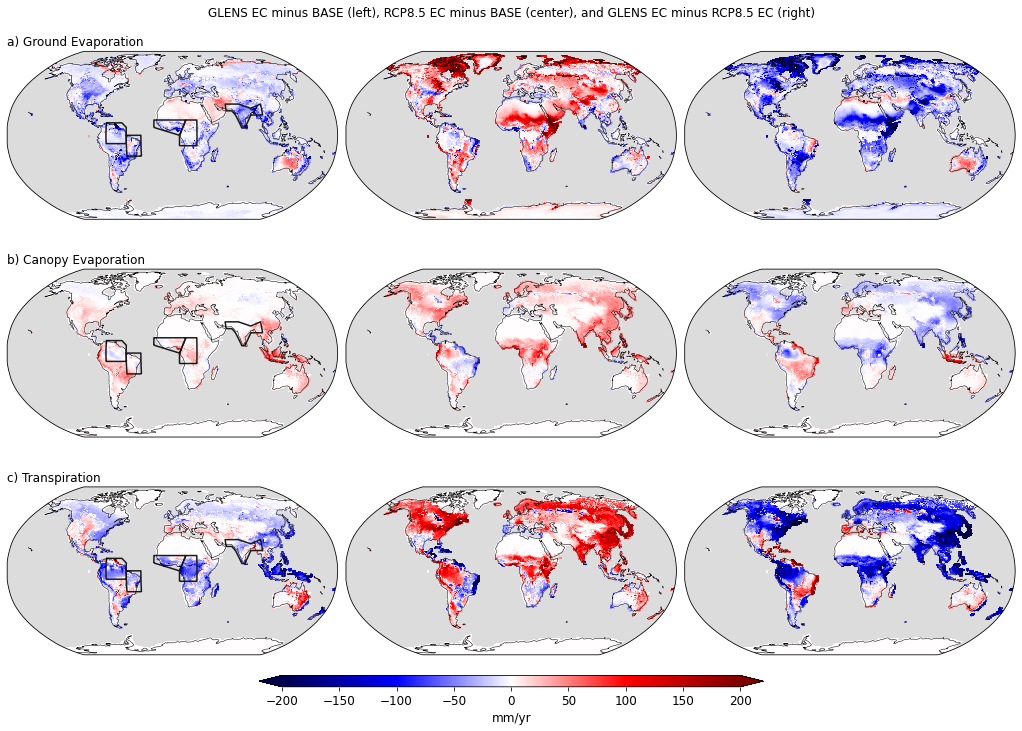

In [70]:
# range
vmin = -200
vmax = 200

# colormap
cmap = plt.get_cmap('seismic')

# define ar6 regions
regions = ["NSA", "NES", "WAF", "CAF", "SAS"]
ar6 = regionmask.defined_regions.ar6.land

fig = plt.figure(figsize=(14, 9))

grid = gridspec.GridSpec(nrows=3, ncols=3, figure=fig, left=0., right=1., top=1., bottom=0.,
                         wspace=0.025, hspace=0.025,)

proj = ccrs.PlateCarree()

ax1 = fig.add_subplot(grid[0], projection=ccrs.Robinson())
ax2 = fig.add_subplot(grid[1], projection=ccrs.Robinson())
ax3 = fig.add_subplot(grid[2], projection=ccrs.Robinson())
ax4 = fig.add_subplot(grid[3], projection=ccrs.Robinson())
ax5 = fig.add_subplot(grid[4], projection=ccrs.Robinson()) 
ax6 = fig.add_subplot(grid[5], projection=ccrs.Robinson()) 
ax7 = fig.add_subplot(grid[6], projection=ccrs.Robinson()) 
ax8 = fig.add_subplot(grid[7], projection=ccrs.Robinson()) 
ax9 = fig.add_subplot(grid[8], projection=ccrs.Robinson()) 

ax1.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax3.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax4.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax5.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax6.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax7.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax8.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax9.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

ax1.coastlines(linewidth=0.5, zorder=10)
ax2.coastlines(linewidth=0.5, zorder=10)
ax3.coastlines(linewidth=0.5, zorder=10)
ax4.coastlines(linewidth=0.5, zorder=10)
ax5.coastlines(linewidth=0.5, zorder=10)
ax6.coastlines(linewidth=0.5, zorder=10)
ax7.coastlines(linewidth=0.5, zorder=10)
ax8.coastlines(linewidth=0.5, zorder=10)
ax9.coastlines(linewidth=0.5, zorder=10)

# add regional boxes to left column only
ar6[regions].plot(ax=ax1, projection=proj, add_label=False)
ar6[regions].plot(ax=ax4, projection=proj, add_label=False)
ar6[regions].plot(ax=ax7, projection=proj, add_label=False)

# -------- plots

# QSOIL
# GLENS minus BASE
field, lon = add_cyclic_point(QSOIL_diffs[0]*86400*365, coord=QSOIL_diffs[0].lon) # convert from mm/s to mm/yr
lat = QSOIL_diffs[0].lat
pl_a = ax1.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)
ax1.set_title('a) Ground Evaporation', fontsize=12, loc='left')
# RCP minus BASE
field, lon = add_cyclic_point(QSOIL_diffs[2]*86400*365, coord=QSOIL_diffs[2].lon) # convert from mm/s to mm/yr
lat = QSOIL_diffs[2].lat
pl_a = ax2.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)
# GLENS minus RCP
field, lon = add_cyclic_point(QSOIL_diffs[1]*86400*365, coord=QSOIL_diffs[1].lon) # convert from mm/s to mm/yr
lat = QSOIL_diffs[1].lat
pl_a = ax3.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)

# QVEGE
# GLENS minus BASE
field, lon = add_cyclic_point(QVEGE_diffs[0]*86400*365, coord=QVEGE_diffs[0].lon)
lat = QVEGE_diffs[0].lat 
pl_b = ax4.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)
ax4.set_title('b) Canopy Evaporation', fontsize=12, loc='left')
# RCP minus BASE
field, lon = add_cyclic_point(QVEGE_diffs[2]*86400*365, coord=QVEGE_diffs[2].lon)
lat = QVEGE_diffs[2].lat 
pl_b = ax5.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)
# GLENS minus RCP
field, lon = add_cyclic_point(QVEGE_diffs[1]*86400*365, coord=QVEGE_diffs[1].lon)
lat = QVEGE_diffs[1].lat 
pl_b = ax6.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)

# QVEGT
# GLENS minus BASE
field, lon = add_cyclic_point(QVEGT_diffs[0]*86400*365, coord=QVEGT_diffs[0].lon)
lat = QVEGT_diffs[0].lat 
pl_c = ax7.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)
ax7.set_title('c) Transpiration', fontsize=12, loc='left')
# RCP minus BASE
field, lon = add_cyclic_point(QVEGT_diffs[2]*86400*365, coord=QVEGT_diffs[2].lon)
lat = QVEGT_diffs[2].lat 
pl_c = ax8.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)
# GLENS minus RCP
field, lon = add_cyclic_point(QVEGT_diffs[1]*86400*365, coord=QVEGT_diffs[1].lon)
lat = QVEGT_diffs[1].lat 
pl_c = ax9.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)

# ----------- colorbar

cax = fig.add_axes([0.25, -0.015, 0.5, 0.0175])
cbar_ = plt.colorbar(pl_a, orientation='horizontal', cax=cax, extend='both')
cbar_.set_label(label = 'mm/yr', size=12)
cbar_.ax.tick_params(labelsize=12)

# ----------- titles

fig.suptitle("GLENS EC minus BASE (left), RCP8.5 EC minus BASE (center), and GLENS EC minus RCP8.5 EC (right)", fontsize=12, y=1.035);

# ----------- save fig

plt.savefig('/glade/work/kdagon/GLENS/Ecosystems/figures/toSCP/QSOIL_QVEGE_QVEGT_diffs_revised_greyocn_regions_3column.png', bbox_inches='tight')
plt.show()
plt.close()

# -------- 